In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import iv, kv
from PIL import Image

In [2]:
# Bessel 1st kind modified functions
I0 = lambda x: iv(0, x)
I1 = lambda x: iv(1, x)

# Bessel 2nd kind modified functions
K0 = lambda x: kv(0, x)
K1 = lambda x: kv(1, x)

In [3]:
def load_constants():
    return Image.open('constants.png')

In [4]:
M = 10
m = 1.5
# J = 2 * pow(M, 2) / (1 + pow(m, 2)) # placeholder for A^2
# A = np.sqrt(J)
r1 = 0.2
b = 0.1
a2 = 0.4
phi = b / a2

def J(M=M, m=m):
    return 2 * pow(M, 2) / (1 + pow(m, 2))

def A(M=M, m=m):
    return np.sqrt(J(M=M, m=m))

def r2(z=0.5, phi=phi):
    """outer cylinder radius equation"""
    return 1 + phi * np.math.cos(2 * np.math.pi * z)
r2v = np.vectorize(r2)

def dpdz(z=0.5, t=1):
    """axial pressure gradient: dp/dz = a1 + a2 cos(2pi wt)"""
    a1 = 0.2
    a2 = 2 * a1
    w = 8
    return - (a1 + a2 * np.math.cos(w * t))

dpdz = np.vectorize(dpdz) # vectorized version of dpdz

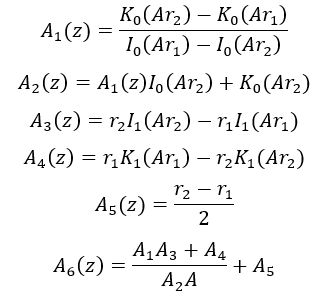

In [5]:
load_constants()

In [6]:
def A1(z=0.5, phi=phi, M=M, m=m):
    r2z = r2v(z, phi=phi)
    part_1 = K0(A(M=M, m=m) * r2z) - K0(A(M=M, m=m) * r1)
    part_2 = I0(A(M=M, m=m) * r1) - I0(A(M=M, m=m) * r2z)
    return part_1 / part_2
A1 = np.vectorize(A1)


def A2(z=0.5, phi=phi, M=M, m=m):
    r2z = r2v(z, phi=phi)
    return A1(z, M=M, m=m) * I0(A(M=M, m=m) * r2z) + K0(A(M=M, m=m) * r2z)
A2 = np.vectorize(A2)


def A3(z=0.5, phi=phi, M=M, m=m):
    r2z = r2v(z, phi=phi)
    return r2z * I1(A(M=M, m=m) * r2z) - r1 * I1(A(M=M, m=m) * r1)
A3 = np.vectorize(A3)

def A4(z=0.5, phi=phi, M=M, m=m):
    r2z = r2v(z, phi=phi)
    return r1 * K1(A(M=M, m=m) * r1) - r2z * K1(A(M=M, m=m) * r2z)
A4 = np.vectorize(A4)

def A5(z=0.5, phi=phi, M=M, m=m):
    return (r2v(z, phi=phi) - r1) / 2
A5 = np.vectorize(A5)

def A6(z=0.5, phi=phi, M=M, m=m):
    part_1 = A1(z, phi=phi, M=M, m=m) * A3(z, phi=phi, M=M, m=m) + A4(z, phi=phi, M=M, m=m)
    part_2 = A2(z, phi=phi, M=M, m=m) * A(M=M, m=m)
    return A5(z, phi=phi, M=M, m=m) + part_1/part_2
A6 = np.vectorize(A6)

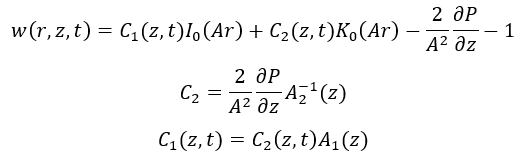

In [7]:
Image.open('w-newtonian-analytic.png')

In [8]:
def c2(z=0.5, t=1, phi=phi, M=M, m=m):
    part_1 = 2 * dpdz(z, t)
    part_2 = np.math.pow(A(M=M, m=m), 2) * A2(z, phi=phi)
    return part_1 / part_2
c2 = np.vectorize(c2)

def c1(z=0.5, t=1, phi=phi, M=M, m=m):
    return c2(z, t, M=M, m=m) * A1(z, phi=phi, M=M, m=m)
c1 = np.vectorize(c1)

def w(r, z=0.5, t=1, phi=phi, M=M, m=m):
    part_1 = c1(z, t, phi=phi, M=M, m=m) * I0(A(M=M, m=m) * r)
    part_2 = c2(z, t, phi=phi, M=M, m=m) * K0(A(M=M, m=m) * r)
    part_3 = 2 * dpdz(z, t) / np.math.pow(A(M=M, m=m), 2)
    return part_1 + part_2 - part_3 - 1
w = np.vectorize(w)

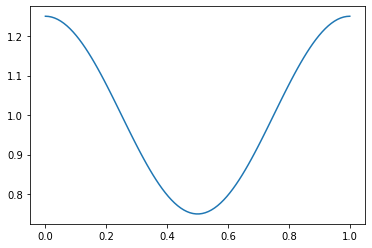

In [9]:
zs = np.linspace(0, 1, 100)
plt.plot(zs, r2v(zs))

In [10]:
nr = 100
nt = 200
rs = np.linspace(r1, r2(), nr)
ts = np.linspace(0, 10, nt)
ws = np.zeros((nr, nt))
for (i, ti) in enumerate(ts):
    for (j, rj) in enumerate(rs):
        ws[j, i] = w(r=rj, t=ti)
# ws[99]
# plt.plot(rs, w(rs, t=ts))

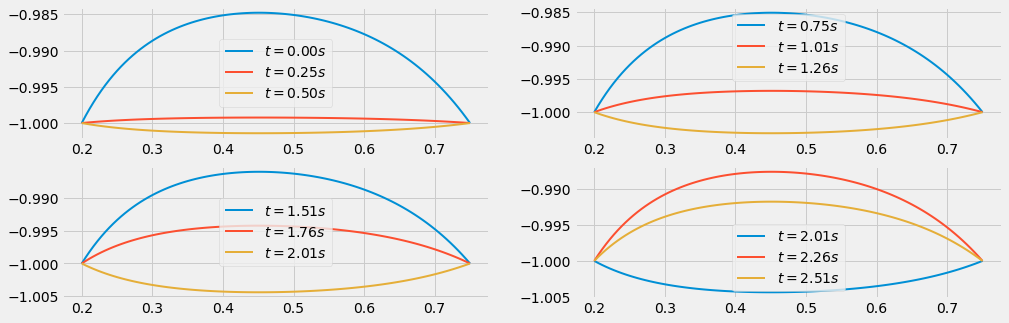

In [11]:
with plt.style.context('fivethirtyeight'):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,5))
    for i in np.array([0, 5, 10]):
        ax1.plot(rs, ws[:, i], label=f'$t={ts[i]:.2f}s$', linewidth=2)
    ax1.legend()
    
#     for i in np.arange(10, 21, 5):
    for i in np.array([15, 20, 25]):
        ax2.plot(rs, ws[:, i], label=f'$t={ts[i]:.2f}s$', linewidth=2)
    ax2.legend()
    
#     for i in np.arange(21, 31, 2):
    for i in np.array([30, 35, 40]):
        ax3.plot(rs, ws[:, i], label=f'$t={ts[i]:.2f}s$', linewidth=2)
    ax3.legend()
    
#     for i in np.arange(31, 39, 2):
    for i in np.array([40, 45, 50]):
        ax4.plot(rs, ws[:, i], label=f'$t={ts[i]:.2f}s$', linewidth=2)
    ax4.legend()

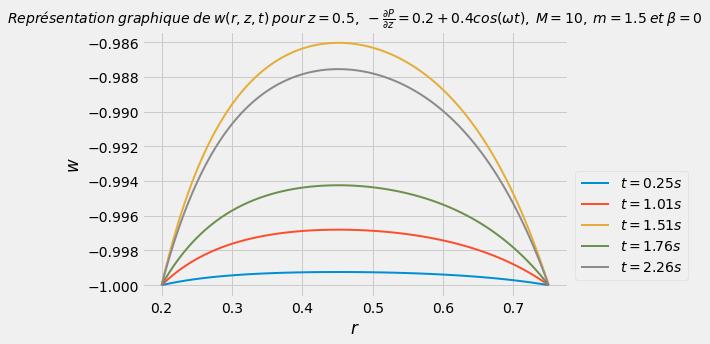

In [13]:
with plt.style.context('fivethirtyeight'):
    for i in np.array([5, 20, 30, 35, 45]):
        plt.plot(rs, ws[:, i], label=f'$t={ts[i]:.2f}s$', linewidth=2)
    plt.legend(framealpha=0.1, edgecolor='black', bbox_to_anchor=(1, 0.5))
    plt.xlabel('$r$')
    plt.ylabel('$w$')
    sp = r'\hspace{0.25}'
    frac = r'-\frac{\partial P}{\partial z}'
    ttl = fr'$Représentation{sp}graphique{sp}de{sp}w(r,z,t){sp}pour{sp}z=0.5,{sp}{frac}=0.2 + 0.4cos(\omega t),{sp}M=10,{sp}m=1.5{sp}et{sp}\beta=0$'
    plt.title(ttl, fontsize=14)
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.savefig('figs/w-newtonian-steady.png', transparent=True, dpi=100)

In [246]:
nr = 100
rs = np.linspace(r1, r2(phi=0.3), nr)
ws_m_1 = np.zeros(nr)
for (i, ri) in enumerate(rs):
    ws_m_1[i] = w(r=ri, t=1, phi=0.3)

In [243]:
ws_m_2 = np.zeros(nr)
for (i, ri) in enumerate(rs):
    ws_m_2[i] = w(r=ri, t=1, M=20)

In [244]:
ws_m_3 = np.zeros(nr)
for (i, ri) in enumerate(rs):
    ws_m_3[i] = w(r=ri, t=1, M=pow(100, 0.5))

In [183]:
def q(z, t, phi=phi, M=M, m=m):
    part_1 = c1(z, t, M=M, m=m) * A3(z, phi=phi, M=M, m=m) / A(M=M, m=m)
    part_2 = c2(z, t, M=M, m=m) * A4(z, phi=phi, M=M, m=m) / A(M=M, m=m)
    part_3 = 2 * A5(z, phi=phi, M=M, m=m) * dpdz(z, t) / np.math.pow(A(M=M, m=m), 2)
    return 2 * np.math.pi * (part_1 + part_2 + part_3 * A5(z, phi=phi, M=M, m=m))
q = np.vectorize(q)

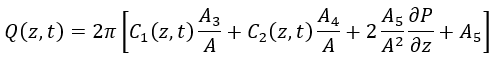

In [14]:
Image.open('q-newtonian-analytic.png')

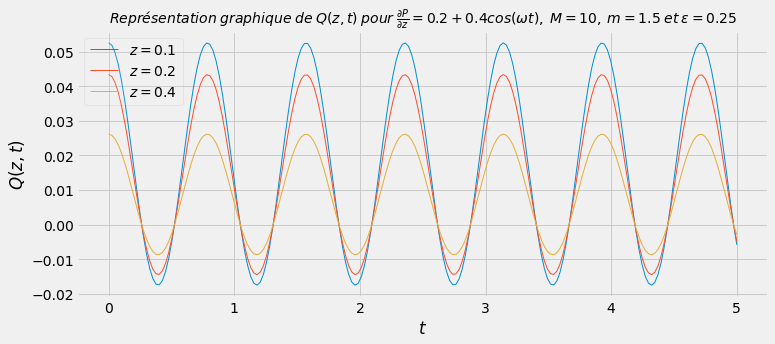

In [186]:
with plt.style.context('fivethirtyeight'):
    ts2 = np.linspace(0, 5, 200)
    plt.plot(ts2, q(0.1, ts2), label='$z=0.1$', linewidth=1)
    plt.plot(ts2, q(0.2, ts2), label='$z=0.2$', linewidth=1)
    plt.plot(ts2, q(0.4, ts2), label='$z=0.4$', linewidth=1)
#     plt.legend()
    plt.legend(framealpha=0.1, edgecolor='black')
    plt.xlabel('$t$')
    plt.ylabel('$Q(z,t)$')
    sp = r'\hspace{0.25}'
    frac = r'\frac{\partial P}{\partial z}'
    ttl = fr'$Représentation{sp}graphique{sp}de{sp}Q(z,t){sp}pour{sp}{frac}=0.2+0.4cos(\omega t),{sp}M=10,{sp}m=1.5{sp}et{sp}\epsilon=0.25$'
    plt.title(ttl, fontsize=14)
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.savefig('figs/q-z-newtonian-steady.png', transparent=True, dpi=100)

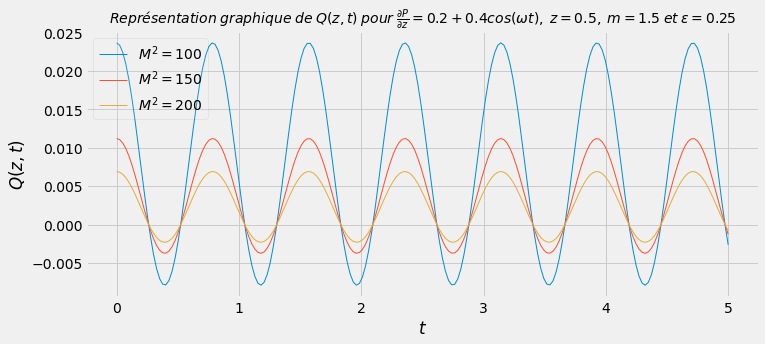

In [189]:
with plt.style.context('fivethirtyeight'):
    ts2 = np.linspace(0, 5, 200)
    plt.plot(ts2, q(0.5, ts2, M=pow(100, 0.5)), label='$M^{2}=100$', linewidth=1)
    plt.plot(ts2, q(0.5, ts2, M=pow(150, 0.5)), label='$M^{2}=150$', linewidth=1)
    plt.plot(ts2, q(0.5, ts2, M=pow(200, 0.5)), label='$M^{2}=200$', linewidth=1)
#     plt.legend()
    plt.legend(framealpha=0.1, edgecolor='black')
    plt.xlabel('$t$')
    plt.ylabel('$Q(z,t)$')
    sp = r'\hspace{0.25}'
    frac = r'\frac{\partial P}{\partial z}'
    ttl = fr'$Représentation{sp}graphique{sp}de{sp}Q(z,t){sp}pour{sp}{frac}=0.2+0.4cos(\omega t),{sp}z=0.5,{sp}m=1.5{sp}et{sp}\epsilon=0.25$'
    plt.title(ttl, fontsize=14)
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.savefig('figs/q-M-newtonian-steady.png', transparent=True, dpi=100)

In [190]:
q_phi_1 = q(0.5, ts2, phi=0.2)
q_phi_2 = q(0.5, ts2, phi=0.4)
q_phi_3 = q(0.5, ts2, phi=0.6)

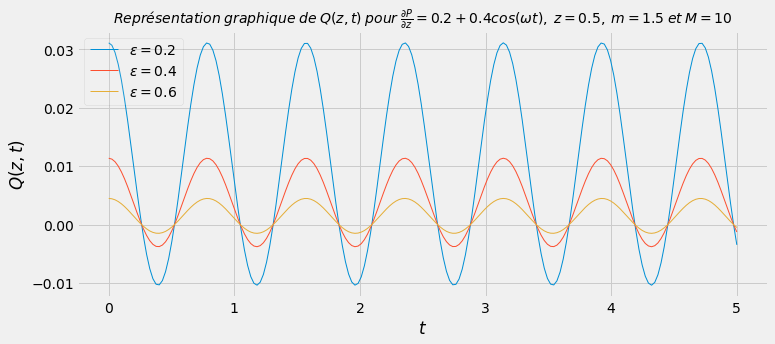

In [193]:
with plt.style.context('fivethirtyeight'):
    ts2 = np.linspace(0, 5, 200)
    plt.plot(ts2, q_phi_1, label='$\epsilon=0.2$', linewidth=1)
    plt.plot(ts2, q_phi_2, label='$\epsilon=0.4$', linewidth=1)
    plt.plot(ts2, q_phi_3, label='$\epsilon=0.6$', linewidth=1)
#     plt.legend()
    plt.legend(framealpha=0.1, edgecolor='black')
    plt.xlabel('$t$')
    plt.ylabel('$Q(z,t)$')
    sp = r'\hspace{0.25}'
    frac = r'\frac{\partial P}{\partial z}'
    ttl = fr'$Représentation{sp}graphique{sp}de{sp}Q(z,t){sp}pour{sp}{frac}=0.2+0.4cos(\omega t),{sp}z=0.5,{sp}m=1.5{sp}et{sp}M=10$'
    plt.title(ttl, fontsize=14)
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
#     plt.savefig('figs/q-M-newtonian-steady.png', transparent=True, dpi=100)

In [16]:
from scipy.integrate import simps

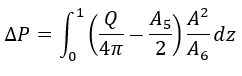

In [17]:
Image.open('dp-newtonian-analytic.png')

In [142]:
def y(q=0, z=0.5, t=1, phi=phi, M=M, m=m):
    part_1 = q / (4 * np.math.pi)
    part_2 = A5(z, phi=phi, M=M, m=m) / 2
    part_3 = np.math.pow(A(M=M, m=m), 2) / A6(z, phi=phi, M=M, m=m)
    return (part_1 - part_2) * part_3
y = np.vectorize(y)

In [85]:
nq = 20
qs = np.linspace(-1, 1, nq)
zs = np.linspace(0, 1, 100)

In [120]:
# occlusion = 0.25
delta_p_1 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.1)
    delta_p_1[i] = simps(ys, zs)

In [121]:
# occlusion = 0.1
delta_p_2 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.2)
    delta_p_2[i] = simps(ys, zs)

In [130]:
# occlusion = 0.5
delta_p_3 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.35)
    delta_p_3[i] = simps(ys, zs)

In [128]:
# occlusion = 0.5
delta_p_4 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, phi=0.5)
    delta_p_4[i] = simps(ys, zs)

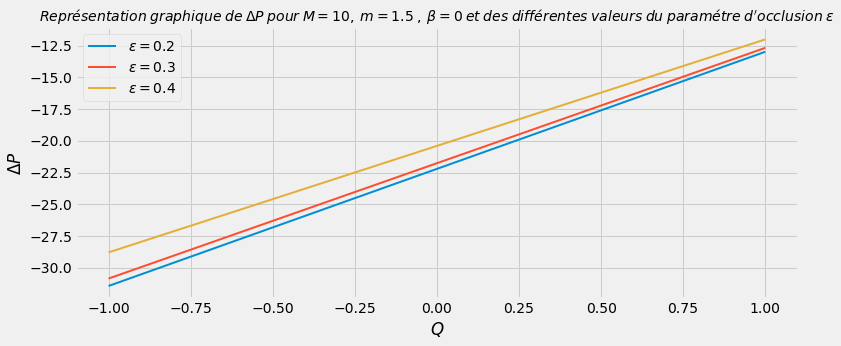

In [181]:
with plt.style.context('fivethirtyeight'):
#     plt.plot(qs, delta_p_1, linewidth=2, label=r'$\epsilon=0.1$', linestyle='dashed')
    plt.plot(qs, delta_p_2, linewidth=2, label=r'$\epsilon=0.2$')
    plt.plot(qs, delta_p_3, linewidth=2, label=r'$\epsilon=0.3$')
    plt.plot(qs, delta_p_4, linewidth=2, label=r'$\epsilon=0.4$')
#     plt.gca().invert_yaxis()
    plt.xlabel('$Q$')
    plt.ylabel('$\Delta P$')
    sp = r'\hspace{0.25}' # 
    ttl = fr"$Représentation{sp}graphique{sp}de{sp}\Delta P{sp}pour{sp}M=10,{sp}m=1.5{sp},{sp}\beta=0{sp}et{sp}des{sp}différentes{sp}valeurs{sp}du{sp}paramétre{sp}d'occlusion{sp}\epsilon$"
    plt.title(ttl, fontsize=14)
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend()
    plt.savefig('figs/deltaP-occlusion-newtonian-steady.png', transparent=True, dpi=100)

In [154]:
# M=10
delta_p_5 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, M=pow(100, 0.5))
    delta_p_5[i] = simps(ys, zs)

In [161]:
# M=40
delta_p_6 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, M=pow(150, 0.5))
    delta_p_6[i] = simps(ys, zs)

In [169]:
# M=40
delta_p_7 = np.zeros(nq)
for (i, q) in enumerate(qs):
    ys = y(q=q, z=zs, M=pow(200, 0.5))
    delta_p_7[i] = simps(ys, zs)

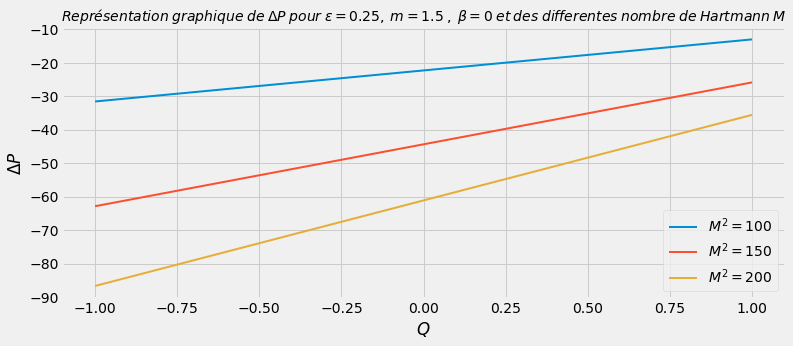

In [178]:
with plt.style.context('fivethirtyeight'):
    plt.plot(qs, delta_p_5, linewidth=2, label=r'$M^{2}=100$')
    plt.plot(qs, delta_p_6, linewidth=2, label=r'$M^{2}=150$')
    plt.plot(qs, delta_p_7, linewidth=2, label=r'$M^{2}=200$')
#     plt.plot(qs, delta_p_4, linewidth=2, label=r'$\epsilon=0.4$')
#     plt.gca().invert_yaxis()
    plt.xlabel('$Q$')
    plt.ylabel('$\Delta P$')
    sp = r'\hspace{0.25}' # {sp}paramétre{sp}d'occlusion{sp}\epsilon
    ttl = fr"$Représentation{sp}graphique{sp}de{sp}\Delta P{sp}pour{sp}\epsilon=0.25,{sp}m=1.5{sp},{sp}\beta=0{sp}et{sp}des{sp}differentes{sp}nombre{sp}de{sp}Hartmann{sp}M$"
    plt.title(ttl, fontsize=14)
    plt.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(12.5, 5.5)
    plt.legend()
    plt.savefig('figs/deltaP-M-newtonian-steady.png', transparent=True, dpi=100)